In [3]:
import pandas as pd
import numpy as np
import math
import re
from geopy.extra.rate_limiter import RateLimiter
from geopy.geocoders import Nominatim
from datetime import date, datetime, timedelta
from shapely.geometry import Point, Polygon
import copy
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# open neighbourhood data file
def open_neighborhoods():
    df = pd.read_csv('SF_neighborhoods.csv')
    return df

In [4]:
# get list of neighbourhoods from neighbourhood datafile
def get_neighborhoods(df):
    neighborhoods = []
    num_neighborhoods = len(df.index)
    for x in range(0,num_neighborhoods):
        neighborhoods.append(df.iloc[x,2])
    return neighborhoods

In [5]:
# generate list of polygons representing each neighbourhood
def generate_neighborhood_polygons(df):
    neighborhoods = []
    num_neighborhoods = len(df.index)
    for x in range(0,num_neighborhoods):
        raw_polygon_data = df.iloc[x,1]
        neighborhood_polygon = generate_polygon(raw_polygon_data)
        neighborhood_name = df.iloc[x,2]
        neighborhood_tuple = (neighborhood_polygon,neighborhood_name)
        neighborhoods.append(neighborhood_tuple)
    return neighborhoods

In [6]:
# generate a polygon
def generate_polygon(raw_polygon_data):
    raw_polygon_data = raw_polygon_data[16:-3]
    coords = ''
    coords_list = []
    for char in raw_polygon_data:
        if char == ' ' or char == ',':
            if coords != '':
                coords_list.append(float(coords))
            coords = ''
        else:
            coords = coords+char
    coords_list.append(float(coords))
    x = 0
    tuple_list = []
    while x < len(coords_list):
        next_tuple = (coords_list[x+1],coords_list[x])
        tuple_list.append(next_tuple)
        x+=2
    polygon = Polygon(tuple_list)
    return polygon

In [7]:
# open original business data file
def open_businesses():
    df = pd.read_csv('SF_registered_business_locations.csv')
    return df

In [8]:
# drop columns deemed unecessary from business data file
def drop_unnecessary_columns(df):
    df = df.drop(columns=['Analysis Neighborhoods','Current Supervisor Districts',
                          'Current Police Districts','SF Find Neighborhoods','Neighborhoods',
                          'LIC Code Description','LIC Code','Transient Occupancy Tax','Parking Tax',
                          'NAICS Code','Mail State','Mail City','Location Id','Business Account Number',
                          'Business Start Date','Business End Date','Ownership Name','Street Address',
                          'City','State','Source Zipcode','Mail Address','Mail Zipcode',
                          'Supervisor District','Business Corridor','NAICS Code Description'])
    return df

In [9]:
# drop incidents prior to uber legislation change
#adjusted crime dataset starts 01/07/2019, business closed one year prior to this are not required 
def drop_end_dates_before_uber_legislation_change(df):
    # give none closed businesses an arbitray future closure date
    df['Location End Date'] = df['Location End Date'].fillna('01/01/2030')
    #convert all date strings to datetime
    df['Location End Date'] = pd.to_datetime(df['Location End Date'])
    df = df[~(df['Location End Date'] < '2018-06-30')]
    return df

In [10]:
# remove businesses without GPS coordinates and place other businesses inside a naeighbourhood polygon using GPS coordinates
def determine_neighborhood_by_geolocation(df, neighborhood_polygons,neighborhoods):
    #replace blank gps coords with arbitrary point a significant distance from san francisco, in the ocean
    df['Business Location'] = df['Business Location'].fillna('POINT (-120.0 30.00)')
    df['Business Location'] = df['Business Location'].str[7:-1]
    df[['Longitude','Latitude']] = df['Business Location'].str.split(" ", expand = True)
    df = convert_gps_to_neighborhood(df,neighborhood_polygons,neighborhoods)
    return df

In [11]:
# place businesses inside a naeighbourhood polygon using GPS coordinates
def convert_gps_to_neighborhood(df,neighborhood_polygons,neighborhoods):
    df['Neighborhood'] = np.nan
    num_records = len(df.index)
    for business_num in range(0,num_records):
        df.iloc[business_num,7] = ''
        if df.iloc[business_num,4] == '-120.0 30.00':
            for neighborhood in neighborhoods:
                if df.iloc[business_num,3] == neighborhood:
                    df.iloc[business_num,7] = neighborhood
            if df.iloc[business_num,7] == '':
                df.iloc[business_num,7] = 'no gps'     
        else:
            shortest_distance = 999999999
            closest_neighborhood = ''
            latitude = float(df.iloc[business_num,6])
            longitude = float(df.iloc[business_num,5])
            point = Point(latitude,longitude)
            for poly_tuple in neighborhood_polygons:
                if poly_tuple[0].contains(point) or poly_tuple[0].touches(point):
                    df.iloc[business_num,7] = poly_tuple[1]
                    break
                else:
                    distance_to_neighborhood = point.distance(poly_tuple[0])
                    if distance_to_neighborhood < shortest_distance:
                        shortest_distance = distance_to_neighborhood
                        closest_neighborhood = poly_tuple[1]
            if df.iloc[business_num,7] == '':
                #if less than half a mile from a neighborhood polygon and sufficiently north to be san francisco
                if shortest_distance < 0.018 and latitude > 37.709126:
                    df.iloc[business_num,7] = closest_neighborhood
    df.reset_index(drop=True, inplace=True)
    df = df[df.Neighborhood != '']
    df = df[df.Neighborhood != 'no gps']
    return df

In [12]:
# remove additional uneccessary columns
def cleanup_columns(df):
    df = df.drop(columns=['Neighborhoods - Analysis Boundaries','Business Location',
                          'Longitude','Latitude'])
    return df

In [13]:
# determine number of business closures per day per neighbourhood
def get_closures_per_day_per_neighborhood(closures):
    closures['Closures'] = 1
    closures['Location End Date'] = pd.to_datetime(closures['Location End Date'])
    closures = closures[closures['Location End Date'].dt.year < 2021]
    closures = closures.groupby(['Location End Date','Neighborhood']).count()
    closures = closures.drop(columns=[ 'DBA Name','Location Start Date'])
    closures = closures.reset_index()
    return closures

In [14]:
# add rows for neighbourhoods which had zero business closures in a given day
def add_zero_closure_neighborhoods(closures, neighborhoods):
    new_rows = pd.DataFrame()
    num_records = len(closures.index)
    current_date = closures.iloc[0,0]
    zero_closure_neighborhoods = copy.deepcopy(neighborhoods)
    for record in range(0,num_records):
        while closures.iloc[record,0] != current_date:
            for neighborhood in zero_closure_neighborhoods:
                new_row = {'Location End Date' : current_date,
                                   'Neighborhood' : neighborhood,
                                   'Closures' : 0}
                new_rows = new_rows.append(new_row,ignore_index=True)
            current_date = current_date + timedelta(days=1)
        if closures.iloc[record,0] == current_date:
            zero_closure_neighborhoods.remove(closures.iloc[record,1])
            if record != num_records-1:
                if closures.iloc[record+1,0] != current_date:
                    for neighborhood in zero_closure_neighborhoods:
                        new_row = {'Location End Date' : current_date,
                                   'Neighborhood' : neighborhood,
                                   'Closures' : 0}
                        new_rows = new_rows.append(new_row,ignore_index=True)
                    zero_closure_neighborhoods = copy.deepcopy(neighborhoods)
                    current_date = current_date + timedelta(days=1)
        if current_date == date (2020,11,12):
            break
    for neighborhood in zero_closure_neighborhoods:
        new_row = {'Location End Date' : current_date,
                    'Neighborhood' : neighborhood,
                    'Closures' : 0}
        new_rows = new_rows.append(new_row,ignore_index=True)
    frames = [closures,new_rows]
    new_record = pd.concat(frames)
    new_record = new_record.sort_values(['Location End Date','Neighborhood'])
    return new_record

In [15]:
# shift closures by a number of days in order to create historic data
def shift_closures(closures,num_days):
    transitional_data = closures.shift(periods=(117*num_days))
    transitional_data = transitional_data['Closures']
    return transitional_data

In [16]:
# generate the last 14 days business closures
def get_last_14_days_closures(closures):
    transitional_data = closures.shift(periods=(117*7))
    transitional_data = transitional_data['Last 7 days closures']
    return transitional_data

In [17]:
# generate the last 28 days business closures
def get_last_28_days_closures(closures):
    transitional_data = closures.shift(periods=(117*14))
    transitional_data = transitional_data['Last 14 days closures']
    return transitional_data

In [18]:
# generate historic business closure data
def generate_new_closure_date_data(closures):
    closures['Closures 1 day ago'] = shift_closures(closures,1)
    closures['Closures 2 days ago'] = shift_closures(closures,2)
    closures['Closures 3 days ago'] = shift_closures(closures,3)
    closures['Closures 4 days ago'] = shift_closures(closures,4)
    closures['Closures 5 days ago'] = shift_closures(closures,5)
    closures['Closures 6 days ago'] = shift_closures(closures,6)
    closures['Closures 7 days ago'] = shift_closures(closures,7)
    closures['Closures 14 days ago'] = shift_closures(closures,14)
    closures['Closures 30 days ago'] = shift_closures(closures,30)
    closures['Closures 365 days ago'] = shift_closures(closures,365)
    closures['Last 7 days closures'] = (closures['Closures 1 day ago']
                                        + closures['Closures 2 days ago']
                                        + closures['Closures 3 days ago']
                                        + closures['Closures 4 days ago']
                                        + closures['Closures 5 days ago']
                                        + closures['Closures 6 days ago']
                                        + closures['Closures 7 days ago'])
    closures['Last 14 days closures'] = (closures['Last 7 days closures']
                                         + get_last_14_days_closures(closures))
    closures['Last 28 days closures'] = (closures['Last 14 days closures']
                                         + get_last_28_days_closures(closures))
    closures = closures.dropna()
    closures = closures[closures['Location End Date'] >= '07-01-2019']
    closures = closures[closures['Location End Date'] <= '11-11-2020']
    #closures = closures[closures[pd.to_datetime(closures['Location End Date'])] < date (2020,11,12)] #final date of SFPD data
    return closures

In [19]:
# determine the number of business openings per neighbourhood
def get_openings_per_day_per_neighborhood(openings):
    openings['Openings'] = 1
    openings['Location Start Date'] = pd.to_datetime(openings['Location Start Date'])
    openings = openings[openings['Location Start Date'].dt.year > 2017]
    openings = openings.groupby(['Location Start Date','Neighborhood']).count()
    openings = openings.drop(columns=[ 'DBA Name','Location End Date'])
    openings = openings.reset_index()
    return openings

In [20]:
# add rows for any neighbourhood with zero business openings on a given day
def add_zero_opening_neighborhoods(openings, neighborhoods):
    new_rows = pd.DataFrame()
    num_records = len(openings.index)
    current_date = openings.iloc[0,0]
    zero_opening_neighborhoods = copy.deepcopy(neighborhoods)
    for record in range(0,num_records):
        while openings.iloc[record,0] != current_date:
            for neighborhood in zero_opening_neighborhoods:
                new_row = {'Location Start Date' : current_date,
                                   'Neighborhood' : neighborhood,
                                   'Openings' : 0}
                new_rows = new_rows.append(new_row,ignore_index=True)
            current_date = current_date + timedelta(days=1)
        if openings.iloc[record,0] == current_date:
            zero_opening_neighborhoods.remove(openings.iloc[record,1])
            if record != num_records-1:
                if openings.iloc[record+1,0] != current_date:
                    for neighborhood in zero_opening_neighborhoods:
                        new_row = {'Location Start Date' : current_date,
                                   'Neighborhood' : neighborhood,
                                   'Openings' : 0}
                        new_rows = new_rows.append(new_row,ignore_index=True)
                    zero_opening_neighborhoods = copy.deepcopy(neighborhoods)
                    current_date = current_date + timedelta(days=1)
        if current_date == date (2020,11,12):
            break
    for neighborhood in zero_opening_neighborhoods:
        new_row = {'Location Start Date' : current_date,
                    'Neighborhood' : neighborhood,
                    'Openings' : 0}
        new_rows = new_rows.append(new_row,ignore_index=True)
    frames = [openings,new_rows]
    new_record = pd.concat(frames)
    new_record = new_record.sort_values(['Location Start Date','Neighborhood'])
    return new_record

In [21]:
# shift business openings by a number of days to create hitoric data
def shift_openings(openings,num_days):
    transitional_data = openings.shift(periods=(117*num_days))
    transitional_data = transitional_data['Openings']
    return transitional_data

In [22]:
# generate the last 14 days business openings data
def get_last_14_days_openings(openings):
    transitional_data = openings.shift(periods=(117*7))
    transitional_data = transitional_data['Last 7 days openings']
    return transitional_data

In [23]:
# generate the last 28 days business openings data
def get_last_28_days_openings(openings):
    transitional_data = openings.shift(periods=(117*14))
    transitional_data = transitional_data['Last 14 days openings']
    return transitional_data

In [24]:
# generate historic business openings data
def generate_new_opening_date_data(openings):
    openings['Openings 1 day ago'] = shift_openings(openings,1)
    openings['Openings 2 days ago'] = shift_openings(openings,2)
    openings['Openings 3 days ago'] = shift_openings(openings,3)
    openings['Openings 4 days ago'] = shift_openings(openings,4)
    openings['Openings 5 days ago'] = shift_openings(openings,5)
    openings['Openings 6 days ago'] = shift_openings(openings,6)
    openings['Openings 7 days ago'] = shift_openings(openings,7)
    openings['Openings 14 days ago'] = shift_openings(openings,14)
    openings['Openings 30 days ago'] = shift_openings(openings,30)
    openings['Openings 365 days ago'] = shift_openings(openings,365)
    openings['Last 7 days openings'] = (openings['Openings 1 day ago']
                                        + openings['Openings 2 days ago']
                                        + openings['Openings 3 days ago']
                                        + openings['Openings 4 days ago']
                                        + openings['Openings 5 days ago']
                                        + openings['Openings 6 days ago']
                                        + openings['Openings 7 days ago'])
    openings['Last 14 days openings'] = (openings['Last 7 days openings']
                                         + get_last_14_days_openings(openings))
    openings['Last 28 days openings'] = (openings['Last 14 days openings']
                                         + get_last_28_days_openings(openings))
    openings = openings.dropna()
    openings = openings[openings['Location Start Date'] >= '07-01-2019']
    openings = openings[openings['Location Start Date'] <= '11-11-2020']
    #openings = openings[openings[pd.to_datetime(openings['Location Start Date'])] < date (2020,11,12)] #final date of SFPD data
    return openings

In [52]:
# generate data placing each open business in each date in which it was trading
def generate_dates_for_each_business(df):
    df['Date'] = np.nan
    df['Date']= pd.to_datetime(df['Date'])
    df['Location Start Date']= pd.to_datetime(df['Location Start Date'])
    df['Location End Date']= pd.to_datetime(df['Location End Date'])
    new_df = pd.DataFrame()
    final_df = pd.DataFrame()
    num_records = len(df.index)
    current_date = datetime(2018, 7, 1) #one year prior to beginning of SFPD data
    end_date = datetime(2020, 11, 11) #final date of SFPD data
    delta = timedelta(days = 1)
    while current_date <= end_date:
        num_records = len(df.index)
        new_df = (df.loc[(df['Location Start Date'] <= current_date) & (current_date < df['Location End Date'])])
        new_df['Date'] = current_date
        final_df = pd.concat((new_df,final_df))
        current_date += delta
    final_df['Number of businesses'] = 1
    final_df = final_df.groupby(['Date','Neighborhood']).count()
    final_df = final_df.drop(columns=[ 'DBA Name','Location Start Date',
                           'Location End Date'])
    return final_df

In [26]:
# shift open businesses by a number of days to create historic data
def shift_days(df,num_days):
    transitional_data = df.shift(periods=(117*num_days))
    transitional_data = transitional_data['Number of businesses']
    return transitional_data

In [27]:
# determine last 14 days open businesses
def get_last_14_days(df):
    transitional_data = df.shift(periods=(117*7))
    transitional_data = transitional_data['Last 7 days']
    return transitional_data

In [28]:
# determine last 28 days open businesses
def get_last_28_days(df):
    transitional_data = df.shift(periods=(117*14))
    transitional_data = transitional_data['Last 14 days']
    return transitional_data

In [29]:
# generate historic open business data
def generate_new_date_data(df):
    df['Businesses 1 day ago'] = shift_days(df,1)
    df['Businesses 2 days ago'] = shift_days(df,2)
    df['Businesses 3 days ago'] = shift_days(df,3)
    df['Businesses 4 days ago'] = shift_days(df,4)
    df['Businesses 5 days ago'] = shift_days(df,5)
    df['Businesses 6 days ago'] = shift_days(df,6)
    df['Businesses 7 days ago'] = shift_days(df,7)
    df['Businesses 14 days ago'] = shift_days(df,14)
    df['Businesses 30 days ago'] = shift_days(df,30)
    df['Businesses 365 days ago'] = shift_days(df,365)
    df = df.dropna()
    return df

In [30]:
df = open_neighborhoods()

Neighborhoods dataset opened.


In [31]:
neighborhoods = get_neighborhoods(df)

In [32]:
neighborhood_polygons = generate_neighborhood_polygons(df)

In [33]:
df = open_businesses()

Business dataset opened.


c:\users\chris\appdata\local\programs\python\python39\lib\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (14) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [34]:
df = drop_unnecessary_columns(df)

In [35]:
df = drop_end_dates_before_uber_legislation_change(df)

In [36]:
df = determine_neighborhood_by_geolocation(df, neighborhood_polygons,neighborhoods)

In [37]:
df = cleanup_columns(df)

In [38]:
df.to_csv('cleaned_businesses.csv', index = False)

In [39]:
closures = get_closures_per_day_per_neighborhood(df)

In [40]:
closures = add_zero_closure_neighborhoods(closures,neighborhoods)

In [41]:
closures = generate_new_closure_date_data(closures)

In [42]:
closures.to_csv('businesses_closures.csv', index = False)

In [43]:
df = pd.read_csv('cleaned_businesses.csv')

In [44]:
openings = get_openings_per_day_per_neighborhood(df)

In [45]:
openings = add_zero_opening_neighborhoods(openings,neighborhoods)

In [46]:
openings = generate_new_opening_date_data(openings)

In [47]:
openings.to_csv('businesses_openings.csv', index = False)

In [54]:
df = pd.read_csv('cleaned_businesses.csv')

In [55]:
df = generate_dates_for_each_business(df)

2018-07-01
2018-07-02
2018-07-03
2018-07-04
2018-07-05
2018-07-06


<ipython-input-52-37a8ebe3ea89>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Date'] = current_date


2018-07-07
2018-07-08
2018-07-09
2018-07-10
2018-07-11
2018-07-12
2018-07-13
2018-07-14
2018-07-15
2018-07-16
2018-07-17
2018-07-18
2018-07-19
2018-07-20
2018-07-21
2018-07-22
2018-07-23
2018-07-24
2018-07-25
2018-07-26
2018-07-27
2018-07-28
2018-07-29
2018-07-30
2018-07-31
2018-08-01
2018-08-02
2018-08-03
2018-08-04
2018-08-05
2018-08-06
2018-08-07
2018-08-08
2018-08-09
2018-08-10
2018-08-11
2018-08-12
2018-08-13
2018-08-14
2018-08-15
2018-08-16
2018-08-17
2018-08-18
2018-08-19
2018-08-20
2018-08-21
2018-08-22
2018-08-23
2018-08-24
2018-08-25
2018-08-26
2018-08-27
2018-08-28
2018-08-29
2018-08-30
2018-08-31
2018-09-01
2018-09-02
2018-09-03
2018-09-04
2018-09-05
2018-09-06
2018-09-07
2018-09-08
2018-09-09
2018-09-10
2018-09-11
2018-09-12
2018-09-13
2018-09-14
2018-09-15
2018-09-16
2018-09-17
2018-09-18
2018-09-19
2018-09-20
2018-09-21
2018-09-22
2018-09-23
2018-09-24
2018-09-25
2018-09-26
2018-09-27
2018-09-28
2018-09-29
2018-09-30
2018-10-01
2018-10-02
2018-10-03
2018-10-04
2018-10-05

2020-07-21
2020-07-22
2020-07-23
2020-07-24
2020-07-25
2020-07-26
2020-07-27
2020-07-28
2020-07-29
2020-07-30
2020-07-31
2020-08-01
2020-08-02
2020-08-03
2020-08-04
2020-08-05
2020-08-06
2020-08-07
2020-08-08
2020-08-09
2020-08-10
2020-08-11
2020-08-12
2020-08-13
2020-08-14
2020-08-15
2020-08-16
2020-08-17
2020-08-18
2020-08-19
2020-08-20
2020-08-21
2020-08-22
2020-08-23
2020-08-24
2020-08-25
2020-08-26
2020-08-27
2020-08-28
2020-08-29
2020-08-30
2020-08-31
2020-09-01
2020-09-02
2020-09-03
2020-09-04
2020-09-05
2020-09-06
2020-09-07
2020-09-08
2020-09-09
2020-09-10
2020-09-11
2020-09-12
2020-09-13
2020-09-14
2020-09-15
2020-09-16
2020-09-17
2020-09-18
2020-09-19
2020-09-20
2020-09-21
2020-09-22
2020-09-23
2020-09-24
2020-09-25
2020-09-26
2020-09-27
2020-09-28
2020-09-29
2020-09-30
2020-10-01
2020-10-02
2020-10-03
2020-10-04
2020-10-05
2020-10-06
2020-10-07
2020-10-08
2020-10-09
2020-10-10
2020-10-11
2020-10-12
2020-10-13
2020-10-14
2020-10-15
2020-10-16
2020-10-17
2020-10-18
2020-10-19

In [56]:
df = generate_new_date_data(df)

In [57]:
df.to_csv('businesses_preprocessed.csv', index = True)

<h3> Visualise active businesses <h3>

In [14]:
df = pd.read_csv('businesses_preprocessed.csv')
df['Date'] = pd.to_datetime(df['Date'])

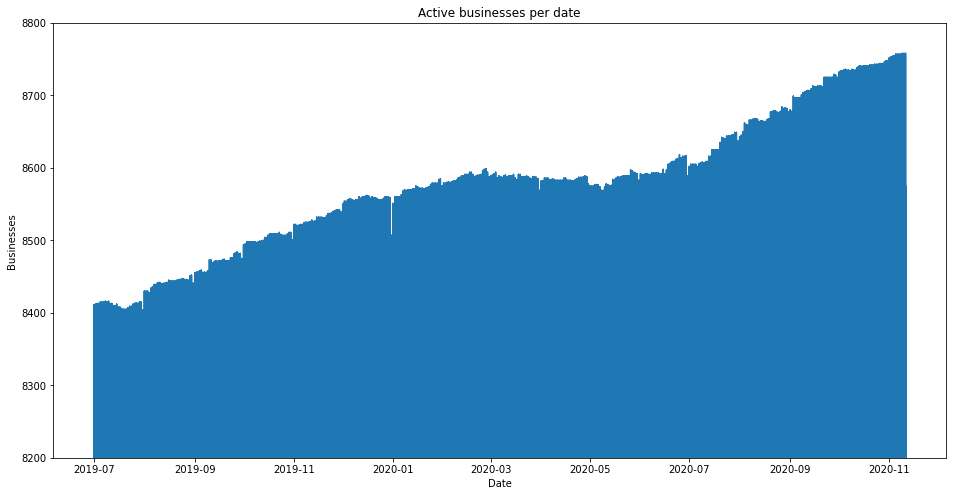

In [15]:
x = df['Date'].tolist()
y = df['Number of businesses'].tolist()
plt.figure(figsize = (16,8))
plt.title('Active businesses per date')
plt.xlabel('Date')
plt.ylabel('Businesses')
plt.ylim(8200, 8800)
plt.fill_between(x, y, interpolate=False)
plt.plot(x,y);

<h3> Visualise businesses closures <h3>

In [33]:
df = pd.read_csv('businesses_closures.csv')
df['Location End Date'] = pd.to_datetime(df['Location End Date'])

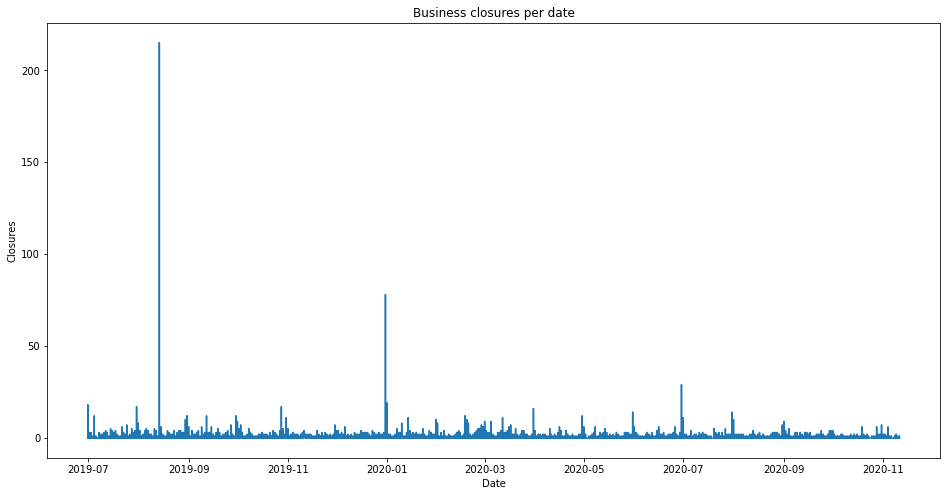

In [34]:
x = df['Location End Date'].tolist()
y = df['Closures'].tolist()
plt.figure(figsize = (16,8))
plt.title('Business closures per date')
plt.xlabel('Date')
plt.ylabel('Closures')
plt.fill_between(x, y, interpolate=True)
plt.plot(x,y);

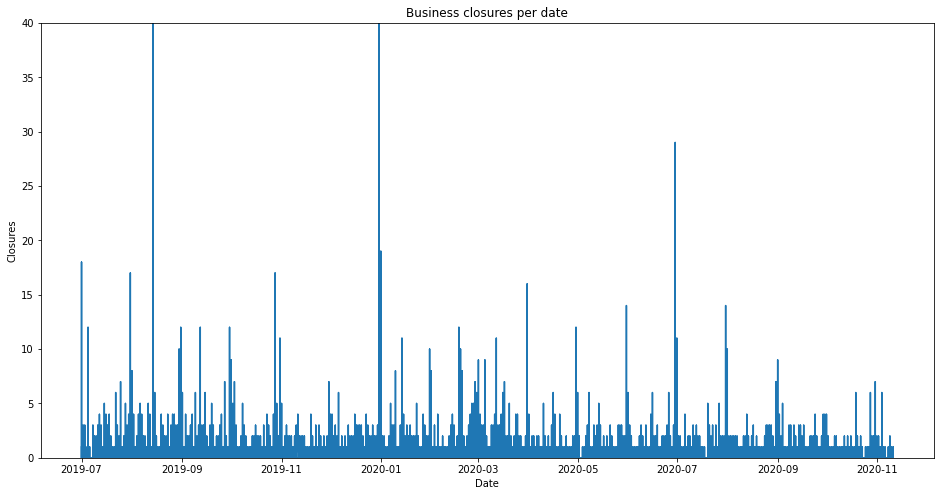

In [35]:
x = df['Location End Date'].tolist()
y = df['Closures'].tolist()
plt.figure(figsize = (16,8))
plt.title('Business closures per date')
plt.xlabel('Date')
plt.ylabel('Closures')
plt.ylim(0, 40)
plt.fill_between(x, y, interpolate=True)
plt.plot(x,y);

<h3> Visualise businesses openings <h3>

In [36]:
df = pd.read_csv('businesses_openings.csv')
df['Location Start Date'] = pd.to_datetime(df['Location Start Date'])

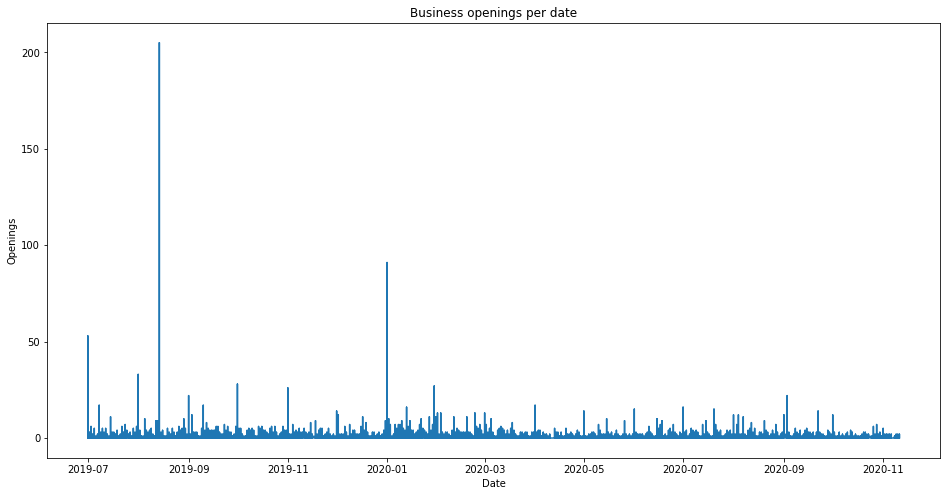

In [37]:
x = df['Location Start Date'].tolist()
y = df['Openings'].tolist()
plt.figure(figsize = (16,8))
plt.title('Business openings per date')
plt.xlabel('Date')
plt.ylabel('Openings')
plt.fill_between(x, y, interpolate=True)
plt.plot(x,y);

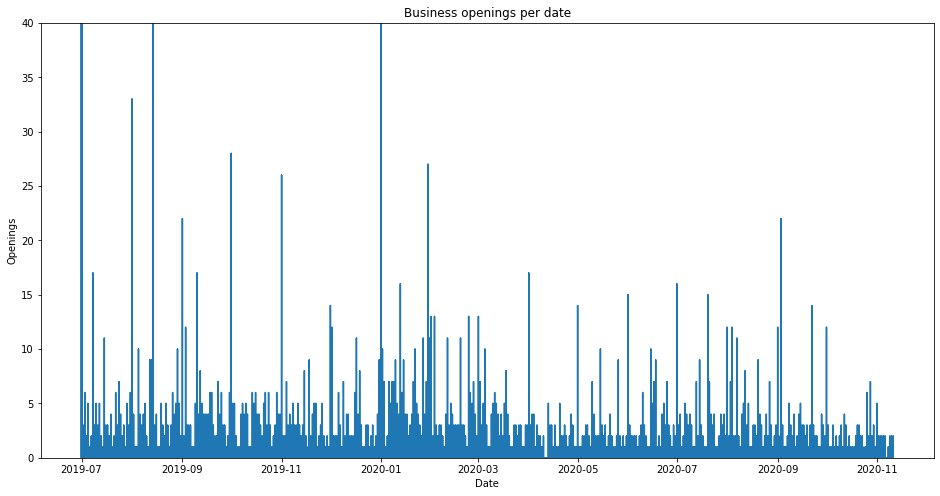

In [39]:
x = df['Location Start Date'].tolist()
y = df['Openings'].tolist()
plt.figure(figsize = (16,8))
plt.title('Business openings per date')
plt.xlabel('Date')
plt.ylabel('Openings')
plt.ylim(0, 40)
plt.fill_between(x, y, interpolate=True)
plt.plot(x,y);